In [1]:
import pandas as pd
import numpy as np
import sys 
import os
import itertools
import time
import random

#import utils
sys.path.insert(0, '../utils/')
from utils_preprocess_v3 import *
from utils_modeling_v9 import *
from utils_plots_v2 import *

#sklearn
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

start_time = time.time()

# load datasets

In [2]:
data = pd.read_csv('../data/datasets_processed/VanAllen_data.csv', index_col = 0)
response = pd.read_csv('../data/datasets_processed/VanAllen_response.csv')
interactome = pd.read_csv('../data/interactomes/inbiomap_processed.txt', sep = '\t')

# preprocess

In [3]:
# get nodes from data and graph
data_nodes = data['node'].tolist()
interactome_nodes = list(set(np.concatenate((interactome['node1'], interactome['node2']))))

# organize data
organize = Preprocessing()
save_location = '../data/reduced_interactomes/reduced_interactome_VanAllen.txt'
organize.transform(data_nodes, interactome_nodes, interactome, data, save_location, load_graph = True)

In [4]:
# extract info from preprocessing
X = organize.sorted_X.T.values
y = response['PFS'].values.reshape(-1,1)
L_norm = organize.L_norm
L = organize.L
L_norm_dagger = scipy.linalg.pinv(L_norm.todense())

g = organize.g
num_to_node = organize.num_to_node

# split for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# scaling X
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# scalying y
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train).reshape(-1)
y_test = scaler_y.transform(y_test).reshape(-1)

In [5]:
# define training params #RERUN WITH SOLVER PARAMS
alpha_list = np.logspace(-1,0,15)
threshold_list = np.logspace(-3,-1,10)
max_features = 10
solver_params = {'max_iters':50000}
solver = cp.SCS

# Lasso 

In [38]:
VanillaLasso = LaplacianRegression('Lasso')
VanillaLasso.fit(X_train, y_train, X_test, y_test, alpha_list, threshold_list, L=None,
                 max_features=max_features, solver=solver, solver_params=solver_params, 
                 force_features=True, verbose=True, n_jobs=15)

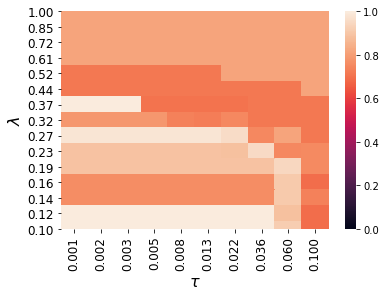

In [39]:
VanillaLasso.plotgridsearch()

In [40]:
print('Test MSE : ' ,VanillaLasso.predict(X_test, y_test))

Test MSE :  0.6940432287679031


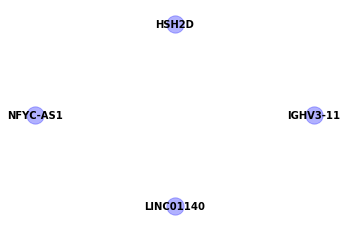

In [41]:
getTranslatedNodes(VanillaLasso.feats_, VanillaLasso.regr_.coef_, num_to_node, g,)

# NTF-Lasso

In [6]:
NTFLasso = LaplacianRegression('Lasso')
NTFLasso.fit(X_train, y_train, X_test, y_test, alpha_list, threshold_list, L=L_norm, 
             max_features=max_features, solver=solver, solver_params=solver_params,
             force_features=True, verbose=True, n_jobs=15,)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  15 | elapsed: 26.6min remaining: 172.8min
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed: 266.9min finished


----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 3837464
eps = 1.00e-04, alpha = 1.50, max_iters = 50000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 34296, constraints m = 34394
Cones:	linear vars: 34294
	soc vars: 100, soc blks: 2
Setup time: 4.98e+02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.57e+21  2.45e+21  1.00e+00 -7.33e+22  2.98e+20  1.44e+22  5.35e-01 
   100| 3.14e-03  3.30e-02  1.72e-02  1.00e+00  9.50e-01  8.61e-16  3.34e+01 
   200| 1.66e-03  4.45e-02  5.59e-02  8.26e-01  9.83e-01  2.73e-15  6.76e+01 
   300| 2

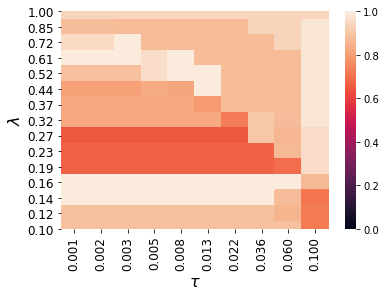

In [8]:
NTFLasso.plotgridsearch()

In [49]:
print('Test MSE : ' ,NTFLasso.predict(X_test, y_test))

Test MSE :  0.6506455591772053


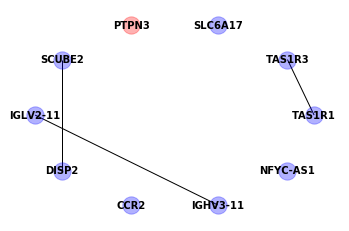

In [51]:
getTranslatedNodes(NTFLasso.feats_, NTFLasso.regr_.coef_, num_to_node, g)

# Ridge

In [ ]:
VanillaRidge = LaplacianRegression('Ridge')
VanillaRidge.fit(X_train, y_train, X_test, y_test, alpha_list, threshold_list, L=None, 
                 max_features = max_features, solver=solver, solver_params=solver_params,
                 force_features=True, verbose=True, n_jobs=15)

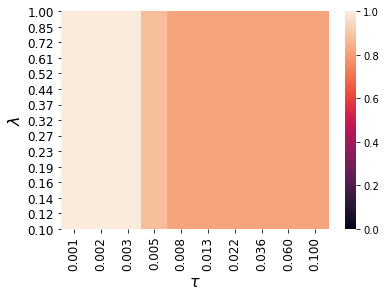

In [53]:
VanillaRidge.plotgridsearch()

In [54]:
print('Test MSE : ' ,VanillaRidge.predict(X_test, y_test))

Test MSE :  0.8792177183874539


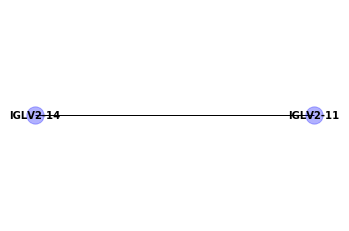

In [55]:
getTranslatedNodes(VanillaRidge.feats_, VanillaRidge.regr_.coef_, num_to_node, g,)

# NTF-Ridge

In [9]:
NTFRidge = LaplacianRegression('Ridge')
NTFRidge.fit(X_train, y_train, X_test, y_test, alpha_list, threshold_list, L=L_norm,
             max_features=max_features, solver=solver, solver_params=solver_params, 
             force_features=True, verbose=True, n_jobs=15)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  15 | elapsed: 150.0min remaining: 975.2min
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed: 164.0min finished


----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 208187165
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 17150, constraints m = 17246
Cones:	soc vars: 17246, soc blks: 3
Setup time: 3.80e+03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.76e+19  7.78e+18  1.00e+00 -4.81e+18  4.31e+16  1.20e+19  2.45e+01 
    33| 9.96e-10  2.93e-11  2.51e-12  1.73e-03  1.73e-03  6.08e-19  5.47e+01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solv

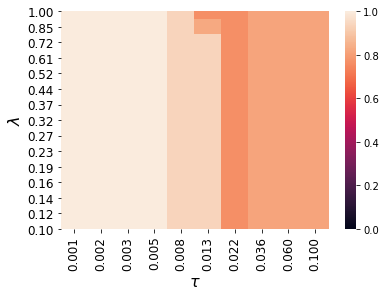

In [14]:
NTFRidge.plotgridsearch()

In [12]:
print('Test MSE : ' ,NTFRidge.predict(X_test, y_test))

Test MSE :  0.7676293690648656


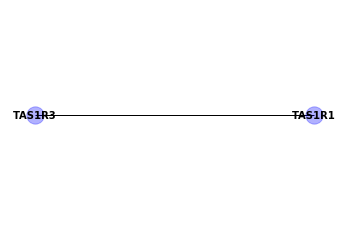

In [13]:
getTranslatedNodes(NTFRidge.feats_, NTFRidge.regr_.coef_, num_to_node, g, )

# TF-Lasso (Graph TF)

In [70]:
TFLasso = LaplacianRegression('Lasso')
TFLasso.fit(X_train, y_train, X_test, y_test, alpha_list, threshold_list, L=L, 
            max_features=max_features, solver=solver, solver_params=solver_params,
            force_features=True, verbose=True, n_jobs=15)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 353.1min finished


----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 3837464
eps = 1.00e-04, alpha = 1.50, max_iters = 50000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 34296, constraints m = 34394
Cones:	linear vars: 34294
	soc vars: 100, soc blks: 2
Setup time: 8.02e+02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 7.87e+21  3.39e+21  1.00e+00 -7.93e+23  8.05e+21  1.69e+23  7.70e-01 
   100| 2.05e-03  3.24e-01  1.86e-01  1.19e+00  6.61e-01  2.68e-14  3.91e+01 
   200| 1.15e-03  1.30e-01  3.21e-02  1.20e+00  1.09e+00  1.79e-15  7.57e+01 
   300| 1

  9600| 1.79e-03  1.02e-01  2.89e-02  7.13e-01  7.85e-01  3.16e-14  3.77e+03 
  9700| 4.00e-04  1.08e-01  8.70e-02  5.54e-01  3.85e-01  1.39e-14  3.81e+03 
  9800| 2.62e-03  1.50e-01  1.55e-01  7.94e-01  1.27e+00  3.79e-15  3.85e+03 
  9900| 7.45e-04  1.21e-01  9.28e-02  4.65e-01  6.62e-01  1.67e-14  3.89e+03 
 10000| 8.46e-04  1.59e-01  6.43e-02  5.85e-01  7.34e-01  2.23e-14  3.93e+03 
 10100| 1.25e-03  1.01e-01  5.28e-02  6.45e-01  7.73e-01  7.89e-15  3.97e+03 
 10200| 1.00e-03  1.26e-01  9.32e-02  6.09e-01  8.37e-01  3.93e-14  4.01e+03 
 10300| 1.44e-03  2.51e-01  7.89e-02  4.24e-01  2.89e-01  1.88e-14  4.04e+03 
 10400| 4.15e-04  8.17e-02  2.88e-02  5.34e-01  5.95e-01  5.88e-15  4.08e+03 
 10500| 4.19e-04  6.80e-02  5.41e-02  5.45e-01  4.38e-01  3.32e-14  4.12e+03 
 10600| 7.14e-04  1.46e-01  1.24e-01  5.62e-01  8.62e-01  1.98e-14  4.16e+03 
 10700| 1.11e-03  1.29e-01  6.71e-02  6.15e-01  7.75e-01  7.46e-15  4.20e+03 
 10800| 1.27e-03  9.84e-02  9.17e-02  6.31e-01  8.60e-01  2.10e-

 20200| 1.60e-04  3.08e-02  3.46e-02  4.52e-01  5.21e-01  5.40e-14  7.96e+03 
 20300| 2.77e-04  3.57e-02  1.54e-02  4.19e-01  3.91e-01  5.14e-14  8.00e+03 
 20400| 1.37e-04  6.61e-02  3.30e-02  4.40e-01  3.80e-01  2.60e-14  8.04e+03 
 20500| 7.09e-05  2.33e-02  9.73e-04  4.41e-01  4.39e-01  3.03e-14  8.08e+03 
 20600| 1.46e-04  2.35e-02  5.15e-03  4.55e-01  4.45e-01  7.00e-14  8.12e+03 
 20700| 1.15e-04  1.96e-02  1.82e-03  4.52e-01  4.48e-01  3.15e-14  8.16e+03 
 20800| 1.95e-03  9.83e-02  6.85e-02  2.47e-01  1.51e-01  2.99e-14  8.20e+03 
 20900| 1.08e-04  2.13e-02  2.81e-02  4.33e-01  3.82e-01  7.15e-15  8.24e+03 
 21000| 3.61e-04  2.48e-02  2.69e-02  4.78e-01  5.32e-01  4.76e-14  8.28e+03 
 21100| 2.55e-04  3.13e-02  2.04e-02  4.67e-01  5.07e-01  3.36e-14  8.32e+03 
 21200| 7.01e-05  2.25e-02  2.49e-02  4.39e-01  3.93e-01  2.64e-15  8.35e+03 
 21300| 4.23e-04  4.84e-02  3.80e-02  4.84e-01  5.62e-01  1.55e-14  8.39e+03 
 21400| 6.80e-05  1.50e-02  3.71e-03  4.47e-01  4.40e-01  2.33e-

 30800| 6.39e-05  4.38e-03  4.13e-03  4.47e-01  4.55e-01  5.11e-15  1.21e+04 
 30900| 1.85e-05  5.17e-03  2.55e-03  4.42e-01  4.47e-01  2.40e-14  1.22e+04 
 31000| 6.38e-05  7.52e-03  8.16e-04  4.35e-01  4.33e-01  1.69e-14  1.22e+04 
 31100| 9.36e-06  1.49e-03  1.13e-03  4.42e-01  4.44e-01  4.71e-14  1.22e+04 
 31200| 8.84e-06  2.57e-03  1.08e-03  4.41e-01  4.43e-01  4.68e-14  1.23e+04 
 31300| 1.79e-05  1.13e-03  7.43e-04  4.43e-01  4.44e-01  2.08e-14  1.23e+04 
 31400| 7.38e-06  9.86e-04  7.37e-05  4.42e-01  4.42e-01  5.74e-14  1.24e+04 
 31500| 2.07e-05  2.29e-03  5.69e-04  4.43e-01  4.41e-01  5.05e-14  1.24e+04 
 31600| 8.70e-06  2.19e-03  1.07e-03  4.41e-01  4.43e-01  7.41e-15  1.24e+04 
 31700| 5.07e-05  2.08e-02  4.38e-03  4.39e-01  4.47e-01  8.24e-15  1.25e+04 
 31800| 9.11e-06  9.45e-04  4.06e-04  4.40e-01  4.39e-01  2.71e-14  1.25e+04 
 31900| 2.77e-05  7.65e-03  1.66e-03  4.39e-01  4.36e-01  3.67e-14  1.25e+04 
 32000| 6.76e-06  1.90e-03  1.60e-03  4.41e-01  4.44e-01  1.27e-

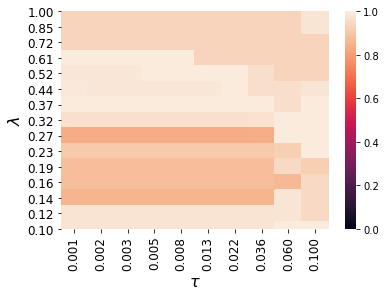

In [71]:
TFLasso.plotgridsearch()

In [72]:
print('Test MSE : ' ,TFLasso.predict(X_test, y_test))

Test MSE :  0.8370549293445585


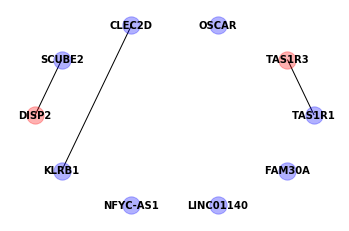

In [73]:
getTranslatedNodes(TFLasso.feats_, TFLasso.regr_.coef_, num_to_node, g,)

# Nonconvex Penalties (MCP, SCAD)

Training is over.
Test MSE :  0.7148551069665416


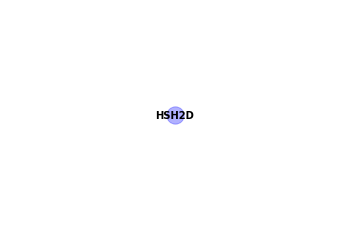

In [26]:
MCP = NonConvexRegression(penalty ='mcp')
MCP.fit(X_train, y_train, X_train, y_train, X_test, y_test,
        alpha_list, threshold_list, max_features = max_features, force_features = True)
print('Test MSE : ' ,MCP.predict(X_test, y_test))
getTranslatedNodes(MCP.feats_, MCP.regr_.coef_, num_to_node, g, save_location = '../figures/VanAllen_MCP.png')

Training is over.
Test MSE :  0.7011718129973022


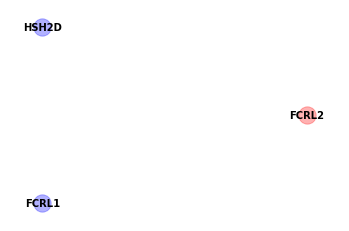

In [27]:
SCAD = NonConvexRegression(penalty = 'scad')
SCAD.fit(X_train, y_train, X_train, y_train, X_test, y_test, 
         alpha_list, threshold_list, max_features = max_features, force_features = True)
print('Test MSE : ' ,SCAD.predict(X_test, y_test))
getTranslatedNodes(SCAD.feats_, SCAD.regr_.coef_, num_to_node, g, save_location = '../figures/VanAllen_SCAD.png')

# NTF-Nonconvex Penalties (NTF-MCP, NTF-SCAD) 

In [28]:
X_train_new =  X_train.dot(L_norm_dagger)
X_test_new = X_test.dot(L_norm_dagger) 

Training is over.
Test MSE :  0.7468270043060778


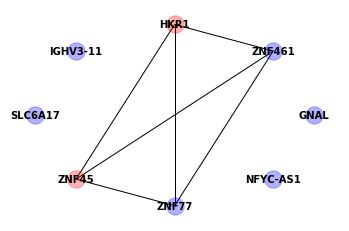

In [29]:
NTFMCP = NonConvexRegression(penalty ='mcp')
NTFMCP.fit(X_train_new, y_train, X_train, y_train, X_test, y_test, 
           alpha_list, threshold_list, max_features = max_features, force_features = True)
print('Test MSE : ' ,NTFMCP.predict(X_test, y_test))
getTranslatedNodes(NTFMCP.feats_, NTFMCP.regr_.coef_, num_to_node, g, save_location = '../figures/VanAllen_NTF-MCP.png')

Training is over.
Test MSE :  0.7015309640105734


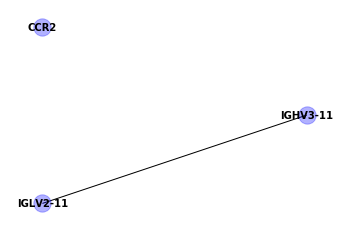

In [30]:
NTFSCAD = NonConvexRegression(penalty ='scad')
NTFSCAD.fit(X_train_new, y_train, X_train, y_train, X_test, y_test, 
            alpha_list, threshold_list, max_features = max_features, force_features = True)
print('Test MSE : ' ,NTFSCAD.predict(X_test, y_test))
getTranslatedNodes(NTFSCAD.feats_, NTFSCAD.regr_.coef_, num_to_node, g, save_location = '../figures/VanAllen_NTF-SCAD.png')

# Shuffled Features

In [59]:
# scramble feature order
random.seed(42)
feat_idx = list(range(X.shape[1]))
random.shuffle(feat_idx)
X_shuf = deepcopy(X[:,feat_idx])

# split for training
X_train, X_test, y_train, y_test = train_test_split(X_shuf, y, test_size=0.20, random_state=42)

# scaling X
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# scalying y
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train).reshape(-1)
y_test = scaler_y.transform(y_test).reshape(-1)

Test MSE :  0.9743198065167753


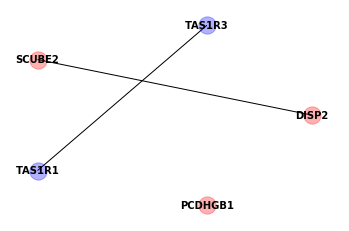

In [63]:
ShuffledNTFLasso = LaplacianRegression('Lasso')
ShuffledNTFLasso.fit(X_train, y_train, X_test, y_test, alpha_list, threshold_list, L=L_norm, 
                     max_features=max_features, solver=solver, solver_params=solver_params 
                     force_features=True, verbose=False, n_jobs=15)
print('Test MSE : ' ,ShuffledNTFLasso.predict(X_test, y_test))
getTranslatedNodes(ShuffledNTFLasso.feats_, ShuffledNTFLasso.regr_.coef_, num_to_node, g, save_location=None)

Training is over.
Test MSE :  0.7148551069665416


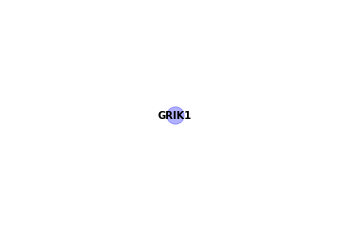

In [60]:
X_train_new =  X_train.dot(L_norm_dagger)
X_test_new = X_test.dot(L_norm_dagger) 

ShuffledNTFMCP = NonConvexRegression(penalty ='mcp')
ShuffledNTFMCP.fit(X_train_new, y_train, X_train, y_train, X_test, y_test, 
                   alpha_list, threshold_list, max_features=max_features, force_features=True)
print('Test MSE : ' ,ShuffledNTFMCP.predict(X_test, y_test))
getTranslatedNodes(ShuffledNTFMCP.feats_, ShuffledNTFMCP.regr_.coef_, num_to_node, g, save_location=None)


Training is over.
Test MSE :  0.7148551069665416


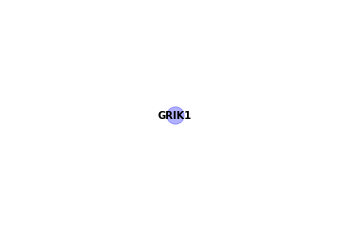

In [61]:
ShuffledNTFSCAD = NonConvexRegression(penalty ='scad')
ShuffledNTFSCAD.fit(X_train_new, y_train, X_train, y_train, X_test, y_test,
                    alpha_list, threshold_list, max_features=max_features, force_features=True)
print('Test MSE : ' ,ShuffledNTFSCAD.predict(X_test, y_test))
getTranslatedNodes(ShuffledNTFSCAD.feats_, ShuffledNTFSCAD.regr_.coef_, num_to_node, g, save_location=None)

#### Elapsed time

In [ ]:
print( 'Elapsed Time : ', time.time() - start_time)